# Libraries

In [4]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from tqdm import tqdm 
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

# Required Links

In [5]:
links=['YouTubeRewind 2015.html',
      'YouTubeRewind 2016.html',
      'YouTubeRewind 2019.html']

videoId=['KK9bwTlAvgo','_GuOjXYl5ew','2lAe1cqCOXo']
videoId=['Rewind 2015','Rewind 2016','Rewind 2019']

# Function

In [6]:
def convertToNumber(txt):
    numbers=re.findall(r'\d+', txt)
    return int(''.join(numbers[ : ]))

In [7]:
def generateData(soup):
    
    #series to store data
    videoData=pd.Series(dtype='object')
    
    # "channel name" is in HTML tag whose class name is "ytd-channel-name"
    videoData['channelName']=soup.find('yt-formatted-string',class_='ytd-channel-name').text
    
    # "video title" is in H1 HTML tag whose class name is "title"
    videoData['title']=soup.find('h1',class_='title').text
    
    # "video length" is in HTML tag whose class name is "ytp-bound-time-right"
    videoData['videoLength']=soup.find(class_='ytp-bound-time-right').text

    # Total "views" of a video is in "<span>" whose class name is "view-count"
    views=soup.find('span',class_='view-count').text # return like "15,113 views"
    videoData['views']=convertToNumber(views) # this will convert str into numeric i.e 15113

    # Total "likes" of a video is in "aria-label" attribute of an 2nd(or 1 index value) HTML tag
    likes=soup.find_all(class_='style-scope ytd-toggle-button-renderer style-text')[1]['aria-label']
    videoData['likes']=convertToNumber(likes)

    # Total "dislikes" of a video is in "aria-label" attribute of an 2nd(or 3 index value) HTML tag
    dislikes=soup.find_all(class_='style-scope ytd-toggle-button-renderer style-text')[3]['aria-label']
    videoData['dislikes']=convertToNumber(dislikes)
    
    #total "comments" of video is in <div id='contents'>
    allComments=soup.find_all('div',id='contents')
    cmts=allComments[0].find_all(id='author-text')
    
    lowerLimit=1 
    upperLimit=201 #total comment I want to extract from a video

    users=[] 
    comments=[]

    #loop to extract each comment and tqdm is used to show progress bars
    for i in tqdm(range(lowerLimit,upperLimit)):
        userName=allComments[0].find_all(id='author-text')[i].text.strip()
        comment=allComments[0].find_all(id='content-text')[i].text.strip()

        users.append(userName)
        comments.append(comment.strip())
    videoData['users']=np.array(users)
    videoData['comments']=np.array(comments)
    return videoData

In [8]:
#this function will generate the dataframe of extracted data into rows and columns
def generateDataframe(videoData):
    df=pd.DataFrame()
    df['username']=videoData['users']
    df['comment']=videoData['comments']
    df['videoid']=videoData['videoid']
    df['title']=videoData['title']
    df['views']=videoData['views']
    df['likes']=videoData['likes']
    df['dislikes']=videoData['dislikes']
    return df

In [9]:
def generatepolarity(df):
    polarity=[]
    
    #loop to go through each comment and get polarity
    for i in df['comment']:
        c1=TextBlob(str(i))
        polarity.append(c1.sentiment[0])
    df['polarity']=polarity    

    #labeling polarity
    label=[]
    for i in df['polarity']:
        if(i<0):
            label.append('negative')#negative
        elif(i==0):
            label.append('neutral')#neutral
        elif(i>0):
            label.append('positive')#positive
    df['label']=label
    return df

# Generate Data

In [10]:
count=1
#iterate to each HTML page/video page
for ids,link in zip(videoId,links):
    
    #pulling data out of HTML
    soup = BeautifulSoup(open(link,'r+',encoding='utf8').read())
    
    videoData=generateData(soup)
    videoData['videoid']=ids
    df=generateDataframe(videoData)
    df=generatepolarity(df)
    
    #creating dataframe for each video
    fn='myDataDf'+str(count)+'.csv'
    df.to_csv(fn,index=False)
    count+=1

100%|██████████| 200/200 [00:47<00:00,  4.20it/s]


In [11]:
df=df.reindex(columns=['videoid', 'title','username', 'comment' , 'views', 'likes', 'dislikes',
       'polarity', 'label'])

In [12]:
df4=pd.concat([pd.read_csv('myDataDf1.csv'),pd.read_csv('myDataDf2.csv'),pd.read_csv('myDataDf3.csv')],ignore_index=True)
df4.to_csv('myDataDf.csv',index=False)
df4.sample(10)

,username,comment,videoid,title,views,likes,dislikes,polarity,label
548,Joebob Derby,Rewind 2020: “top 10 demonetized videos”,Rewind 2019,YouTube Rewind 2019: For the Record | #YouTube...,98205677,3332526,8749993,0.500000,positive
63,Bob Smith,"I've been watching every rewind since 2012, co...",Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,-0.750000,negative
95,JIVIN J,2015 rewind-perfection by Youtube \n2019 rewin...,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,0.000000,neutral
367,Scott Arcement,2016: This is awful\n2019: This is fine,Rewind 2016,YouTube Rewind: The Ultimate 2016 Challenge | ...,236654813,3904159,563822,-0.291667,negative
565,Quin Roseman,this is my worst nightmare of a comment section,Rewind 2019,YouTube Rewind 2019: For the Record | #YouTube...,98205677,3332526,8749993,-1.000000,negative
169,DaSpammer58,Rewind 2015: let’s have a party bus!\nRewind 2...,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,0.000000,neutral
327,ArySilvi 98,Who remember this beautiful moments..?,Rewind 2016,YouTube Rewind: The Ultimate 2016 Challenge | ...,236654813,3904159,563822,0.850000,positive
489,TomPaulsen21 -,YouTube last year: the most disliked video.\nY...,Rewind 2019,YouTube Rewind 2019: For the Record | #YouTube...,98205677,3332526,8749993,0.200000,positive
468,Yaboy Player,Me: watches a quarter of the video\n\nMe: stop...,Rewind 2019,YouTube Rewind 2019: For the Record | #YouTube...,98205677,3332526,8749993,0.000000,neutral
410,Double A Food Reveiw,Remember when you had an english project due t...,Rewind 2019,YouTube Rewind 2019: For the Record | #YouTube...,98205677,3332526,8749993,0.141667,positive


# Data Visualization

In [13]:
df=pd.read_csv('myDataDf.csv')
df.head()

,username,comment,videoid,title,views,likes,dislikes,polarity,label
0,Maisie Mears,Only here because 2019 wasn’t even a rewind ffs,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,0.00,neutral
1,iambirb,5 years later and I just now realize the dance...,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,0.00,neutral
2,juliaa,this made me so nostalgic i felt like crying. ...,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,0.10,positive
3,Erf Boy,Only people who hated Rewind 2019 can like thi...,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,-0.45,negative
4,Mohit,who else is here after the terrible 2018 rewind?,Rewind 2015,YouTube Rewind: Now Watch Me 2015 | #YouTubeRe...,151641936,2899029,208570,-1.00,negative


## 1) Analysing Polarity

In [14]:
df2=pd.crosstab(df['videoid'],df['label'])
df2['total']=df2.sum(axis=1)
df2['posFraction']=df2['positive']/df2['total']
df2['negFraction']=df2['negative']/df2['total']
df2['neuFraction']=df2['neutral']/df2['total']
df2

label,negative,neutral,positive,total,posFraction,negFraction,neuFraction
videoid,,,,,,,
Rewind 2015,32,73,95,200,0.475,0.16,0.365
Rewind 2016,32,87,81,200,0.405,0.16,0.435
Rewind 2019,46,74,80,200,0.400,0.23,0.370


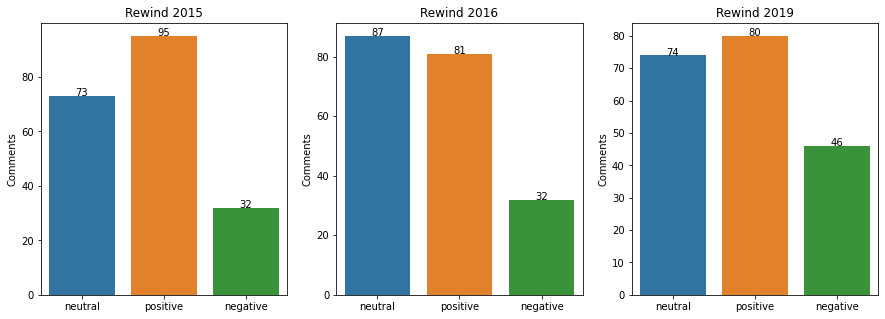

In [16]:
fig,axs=plt.subplots(ncols=3)
fig.set_size_inches(15,5)
sns.barplot(df.label.unique(),df2[df.label.unique()].loc['Rewind 2015'],ax=axs[0])
sns.barplot(df.label.unique(),df2[df.label.unique()].loc['Rewind 2016'],ax=axs[1])
sns.barplot(df.label.unique(),df2[df.label.unique()].loc['Rewind 2019'],ax=axs[2])

for i in range(len(df2[df.label.unique()].index)):
    col=df2[df.label.unique()].index[i]
    for x, y in enumerate(df2[df.label.unique()].loc[col]):
        axs[i].text(x, y, str(y), ha="center")
    axs[i].set_ylabel("Comments")
    axs[i].set_title(col)
plt.show();

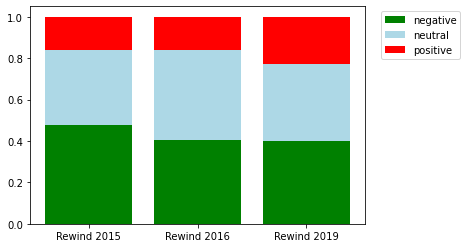

In [17]:
plt.bar(df2.index, df2.posFraction, color='Green');
plt.bar(df2.index, df2.neuFraction, bottom=df2.posFraction, color='lightblue');
plt.bar(df2.index, df2.negFraction, bottom=df2.posFraction + df2.neuFraction, color='Red');
plt.legend(df2.columns,bbox_to_anchor=(0.3, 0.9, 1., .102))
plt.show();

In [18]:
df2[['negative','neutral','positive']]

label,negative,neutral,positive
videoid,,,
Rewind 2015,32,73,95
Rewind 2016,32,87,81
Rewind 2019,46,74,80


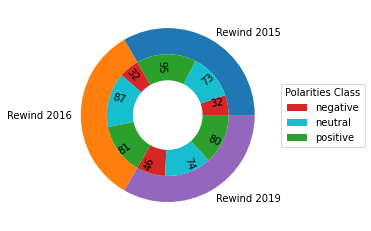

In [19]:
cmap = plt.get_cmap('tab10')
outer_colors = cmap(np.array([0, 1, 4]))
inner_colors = cmap(np.array([3, 9, 2, 3, 9, 2, 3, 9, 2]))

plt.pie(df2.total, labels=df2.index, wedgeprops=dict(width=0.3),colors=outer_colors);
p1 =plt.pie(df2[['negative','neutral','positive']].values.flatten(),
                                  labels = df2[['negative','neutral','positive']].values.flatten(),
                                  labeldistance=0.7 ,rotatelabels=True,radius=0.7, wedgeprops=dict(width=0.3),
                                  colors=inner_colors,frame=True);
plt.legend(p1[0], ['negative','neutral','positive'],title="Polarities Class",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show();

## 2) Analysing Views

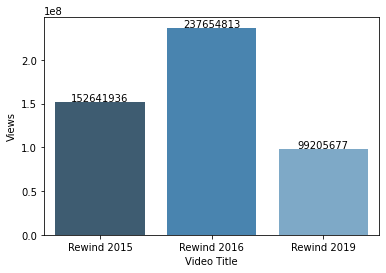

In [20]:
df2=df[['videoid','views']].groupby('videoid').mean()

sns.barplot(df2.index, df2.views, color='blue',palette="Blues_d");
plt.xlabel('Video Title')
plt.ylabel('Views')
for x, val in enumerate(df2.index):
    y = df2.loc[val, 'views']+1000000
    plt.text(x, y, str(y), ha="center");

## 3) Analysing Likes and Dislikes

In [21]:
df2=df[['videoid','likes','dislikes']].groupby('videoid').mean()
df2['total']=df2.sum(axis=1)
df2['likesFraction']=df2['likes']/df2['total']
df2['dislikesFraction']=df2['dislikes']/df2['total']
df2

,likes,dislikes,total,likesFraction,dislikesFraction
videoid,,,,,
Rewind 2015,2899029,208570,3107599,0.932884,0.067116
Rewind 2016,3904159,563822,4467981,0.873808,0.126192
Rewind 2019,3332526,8749993,12082519,0.275814,0.724186


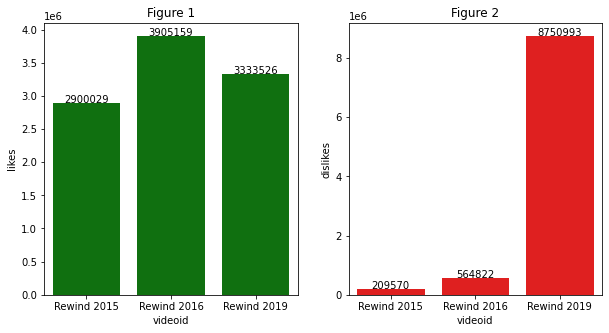

In [22]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(10,5)
sns.barplot(df2.index, df2.likes, color='Green',ax=axs[0]);
sns.barplot(df2.index, df2.dislikes, color='red',ax=axs[1]);
for x, val in enumerate(df2.index):
    y1 = df2.loc[val, 'likes']+1000
    y2 = df2.loc[val, 'dislikes']+1000
    axs[0].text(x, y1, str(y1), ha="center");
    axs[1].text(x, y2, str(y2), ha="center");
    axs[0].set_title("Figure 1")
    axs[1].set_title("Figure 2")
plt.show()

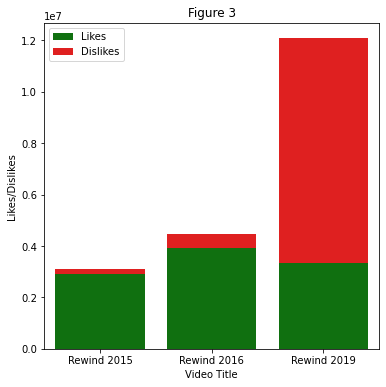

In [23]:
fig = plt.gcf();
fig.set_size_inches(6, 6);
sns.barplot(df2.index, df2.likes, color='Green',label='Likes');
sns.barplot(df2.index, df2.dislikes, bottom=df2.likes, color='red',label='Dislikes');
plt.ylabel("Likes/Dislikes")
plt.xlabel("Video Title")
plt.title("Figure 3")
plt.legend()
plt.show();

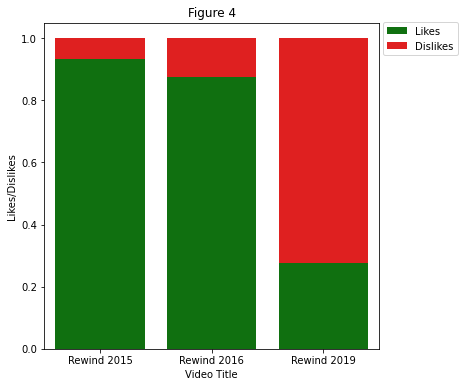

In [24]:
fig = plt.gcf();
fig.set_size_inches(6, 6);
p1=sns.barplot(df2.index, df2.likesFraction, color='Green',label='Likes');
p2=sns.barplot(df2.index, df2.dislikesFraction, bottom=df2.likesFraction, color='red',label='Dislikes');
plt.ylabel("Likes/Dislikes")
plt.xlabel("Video Title")
plt.legend(bbox_to_anchor=(0.25, 0.915, 1., .102))
plt.title("Figure 4")
plt.show();